In [255]:
#importacion general de librerias y de visualizacion (matplotlib y seaborn)
%matplotlib notebook
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


In [256]:
df = pd.read_csv('train.csv', encoding='utf-8')

df['location'].fillna(value='sin location', inplace=True)
df['keyword'].fillna(value='sin keyword', inplace=True)

df['text'] = df.text.str.lower()
df['text'] = df.text.str.replace('%20', ' ')

df['keyword'] = df.keyword.str.lower()
df['keyword'] = df.keyword.str.replace('%20', ' ')

df['location'] = df.location.str.lower()
df['location'] = df.location.str.replace('%20', ' ')

# Funciones Generales

In [257]:

NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']
PAIS_DESASTRES = ['usa', 'united states', 'canada', 'japan', 'nigeria']
CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii']

TRAGEDIAS_CONOCIDAS = ['mh370', 'huracan', ]

CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def print_metrics(y_test, y_pred):
    #auc = metrics.roc_auc_score(y_test, y_pred) #AUC
    precision = metrics.precision_score(y_test, y_pred) #Precisión
    accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy
    f1 = metrics.f1_score(y_test, y_pred) #F1 
    conf_matrix = metrics.confusion_matrix(y_test, y_pred) #Matriz de confusión
    #recall = metrics.recall_score(y_test, y_pred) #Recall 
    print('Accuracy:', accuracy, 'F1: ', f1,  'Precisión: ', precision)

# Referencia a un diario o noticiero
def news_ref(text):
    for word in text.split():
        if word in NOTICIEROS:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False

In [258]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import re, string
from string import punctuation


stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def unir_texto(text):
    return ( " ".join(text))

#englishStemmer=SnowballStemmer("english")
def limpiar_texto(word):
    word = word.replace('#', '')
    if word.startswith('http') | word.startswith('http'):
        word = ''
    word = re.sub('[^A-Za-z0-9]+', ' ', word)
    return word

# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
lemmatizer = WordNetLemmatizer()
def lematizar(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stops:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text
def formatear_texto(text):
    text = limpiar_texto(text)
    text = lematizar(text)
    text = unir_texto(text)
    return text
    

In [259]:
df['text_sin_sw'] = df.text.apply(formatear_texto)

df['length'] = df.text_sin_sw.apply(len)


df['http'] = df.text.str.contains('http')
df['carita_alegre'] = df.text.str.contains(':\)')
df['carita_triste'] = df.text.str.contains(':\(')
#df['cant_stopwords'] = df.text.apply(lambda x: len(set(x.split()) & stops))


df['ref_noticias'] = df.text_sin_sw.apply(news_ref)

df['zona_desastres'] = df.text_sin_sw.apply(es_ciudad_de_desastres) |\
                        df.text_sin_sw.apply(es_pais_de_desastres)


'''
X = df[['location', 'text_sin_sw', 'target', 'http_hashtag', 'carita_alegre', 'carita_triste', 'length_verdadero', 'ref_noticias', 'zona_desastres']].join(encoded)
X[X.target == 1].sample(400).to_csv('data/tw_reales.csv')
X[X.target == 0].sample(400).to_csv('data/tw_falsos.csv')
df.sample(100)
'''

#serie = df[df.target == 0]['text_sin_sw'].str.split(expand=True).stack().value_counts()
#serie.to_csv('data/tw_top_words_0.csv')
#df[df.zona_desastres == 1].to_csv('data/sampple.csv')

df

,id,keyword,location,text,target,text_sin_sw,length,http,carita_alegre,carita_triste,ref_noticias,zona_desastres
0,1,sin keyword,sin location,our deeds are the reason of this #earthquake m...,1,deed reason earthquake may allah forgive u,42,False,False,False,False,False
1,4,sin keyword,sin location,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada,37,False,False,False,False,True
2,5,sin keyword,sin location,all residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,79,False,False,False,False,False
3,6,sin keyword,sin location,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfire evacuation orde...,58,False,False,False,False,True
4,7,sin keyword,sin location,just got sent this photo from ruby #alaska as ...,1,get sent photo ruby alaska smoke wildfire pour...,54,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding a bridge collapse int...,1,two giant crane hold bridge collapse nearby ho...,67,True,False,False,False,False
7609,10870,sin keyword,sin location,@aria_ahrary @thetawniest the out of control w...,1,aria ahrary thetawniest control wild fire cali...,85,False,False,False,False,True
7610,10871,sin keyword,sin location,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m1 94 01 04 utc 5km volcano hawaii http co zdt...,53,True,False,False,False,True
7611,10872,sin keyword,sin location,police investigating after an e-bike collided ...,1,police investigate e bike collide car little p...,106,False,False,False,False,False


# Pruebas

In [260]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 91)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

Accuracy: 0.7914915966386554 F1:  0.7229588276343336 Precisión:  0.8144654088050315


# Buscando un K 'bueno'

In [261]:
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()


<IPython.core.display.Javascript object>

# Datos de entrenamiento

In [262]:
from sklearn.preprocessing import LabelEncoder


#Codificando como categorias
#cat_features = ['ciudad_text', 'ciudad_location', 'pais_text', 'pais_location']
#encoder = LabelEncoder()

# Apliico a cada columna
#encoded = df[cat_features].apply(encoder.fit_transform)


#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

#y = df['target']
#columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
#X = df.drop(columnas, axis=1)




# 1. KNN

In [263]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 91)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

Accuracy: 0.7914915966386554 F1:  0.7229588276343336 Precisión:  0.8144654088050315


# 2 . Regresión Logística

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
LR = LogisticRegression(penalty='l2', max_iter=500, C=3, random_state = 1)
LR.fit(X_train, y_train)

#Métricas
y_pred_lr = LR.predict(X_test)
print_metrics(y_test, y_pred_lr)



Accuracy: 0.8177521008403361 F1:  0.772160210111622 Precisión:  0.8099173553719008


# 3. Multinomial NB

In [266]:
from sklearn.naive_bayes import MultinomialNB

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred_gnb = MNB.predict(X_test)

print_metrics(y_test, y_pred_gnb)

Accuracy: 0.8061974789915967 F1:  0.7417774667599721 Precisión:  0.8386075949367089


# 4. RFC

Accuracy: 0.6349789915966386 F1:  0.5394300861497682 Precisión:  0.5716292134831461


<IPython.core.display.Javascript object>


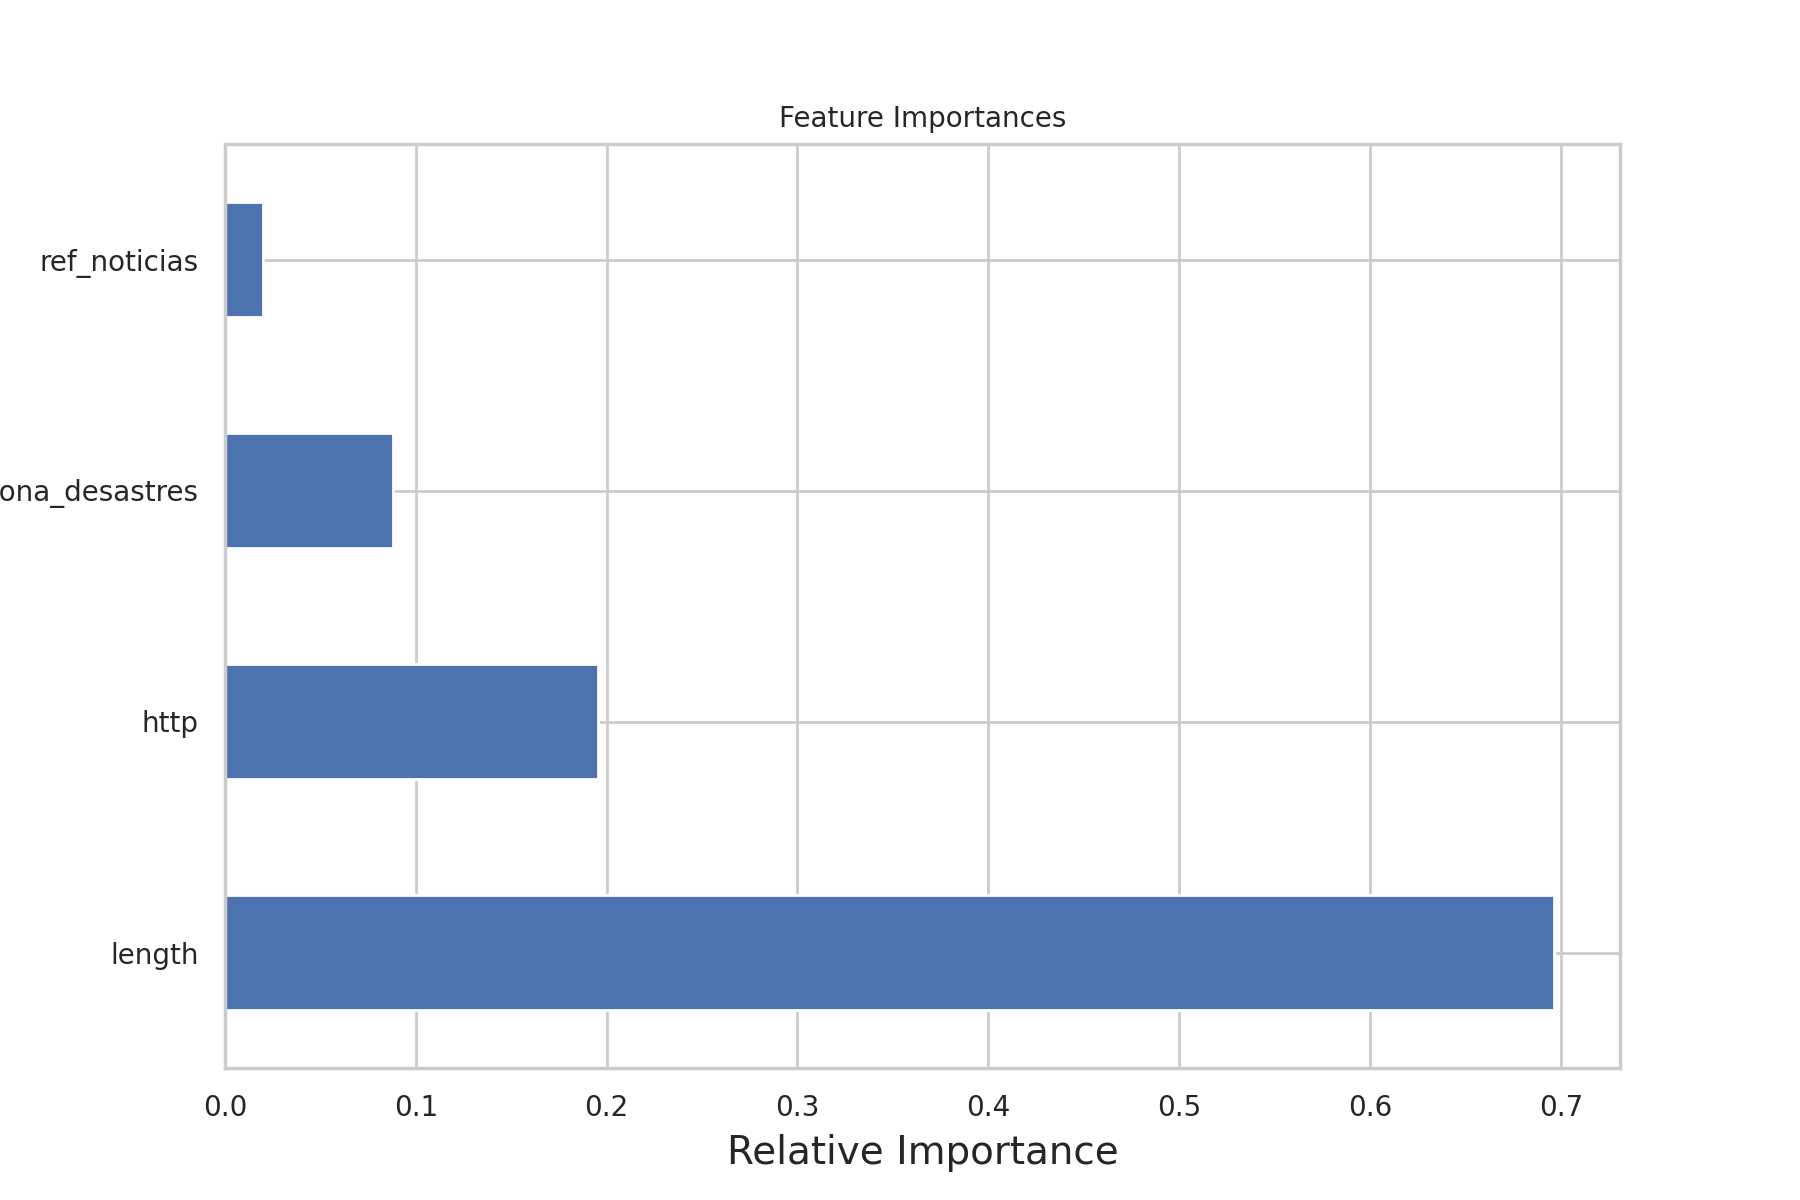

Feature ranking:
length                  69.6212000325
http                    19.5583432512
zona_desastres           8.8170709723
ref_noticias             2.0033857439
dtype: float64


In [273]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Datos de entrenameinto
X = df[['http', 'length', 'ref_noticias', 'zona_desastres']]

y = df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
#X = df.drop(columnas, axis=1)

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Train
RFC = RandomForestClassifier(n_estimators = 20,  n_jobs=-1, random_state = 0)
RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)

#Features

features = np.array(X.columns)
importances = RFC.feature_importances_
indices = np.argsort(importances)
    
serie = (pd.Series(RFC.feature_importances_, index=X_train.columns).nlargest(X_train.shape[1]))

plt.figure()
serie.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

# Print the feature ranking
print("Feature ranking:")

print(serie*100)
